# Project: Ukrainian coffee market segments


#### Abstract
Coffee has become an integral part of our everyday lives. We start the day with it, have one with friends/colleagues over a break, and even go on coffee dates. It's not surprising that almost any establishment has a variety available 24/7. Why is it so? 

The answer is pretty simple - it brings a lot of money. To illustrate the impact of coffee on our daily life, let's look at some numbers. In 2020/2021 the total coffee consumption worldwide had been estimated to be 166.63 million 60kg bags [1]. Moreover, within five years, the market is estimated to bring $201.4 billion [2]. It makes sense why coffee stands are popping up on every corner, doesn't it? 


#### Introduction

The analysis was conducted to understand the current coffee market in Ukraine. This information would then be used to create marketing plans to expand the businesses. To understand the market, we were supplemented with a dataset consisting of 200 entries that were evenly spread across 10 regions. It's also important to mention that, even though there are ten cities, the number of unique regions is nine. There are two cities, Khrivoy Rog and Dnipro, that represent the same Dnipropetrovsk region. 

This notebook discusses the methods that were used for data cleaning, exploratory data analysis, feature and model selection. Since the end-goal was to find the segments, there was a need to select an appropriate unsupervised algortihm. The dataset had more categorical values than numeric, there were two algrotihms implemented: K-Means and K-Prototype. To facilitate a smooth comprehension of the steps and findings to people of both technical and non-technical backgrounds, each code block explains the tools being used as well as the findings of using them.  


### Table of Content

* [Dataset](#dataset)
* [Data Cleaning](#clean)
* [Exploratory Data Analysis](#explore)
* [Model Selection](#eval)
* [Results](#results)
* [Final Recommendations](#recommend)

### Dataset <a class="anchor" id="dataset"/>

---

The analysis was conducted to understand the current coffee market in Ukraine. This information would then be used to create marketing plans to expand the business nationally. To understand the market, we were supplemented with a dataset that was made of 200 data entries that were evenly spread across 10 regions.

| Column | Description |
| --- | --- | 
| Region | One of 10 possible regions where coffee shops are located |
| Place name | Name of the shop |
| Place type | Type of coffee shop (e.g., "Cafe", "Espresso Bar", ...) |
| Rating | Coffe shop rating (on a 5 point scale) |
| Reviews | Number of reviews provided for the shop | 
| Price | Price category (\\$, \\$\\$, \\$\\$\\$) | 
| Delivery option | True/False, describing whether there is or isn't a delivery option | 
| Dine in option | True/False, describing whether there is or isn't a dine-in option | 
| Takeout option | True/False, describing whether there is or isn't a takeout option |


#### 💡 Insights

- Each region represent a unique county (oblast) except for Khrivoy Rog and Dnipro, both of which belong to Dnipropetrovsk oblast. Therefore, there are officially 9 unique regions present.  
- The regions can be divided into the three categories depending on their population which ranges from 280,000 (Poltava) to almost 3,000,000 (Kiev). The categories are: metropolis, city, and county. 


In [1]:
# import essential packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ppscore as pps
import missingno as msno

import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from kmodes.kprototypes import KPrototypes

from utils import viz

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# set visualization parameters
plt.rcParams["figure.figsize"] = (10, 5)
sns.set()
sns.set_palette('dark')

In [2]:
# read data and show the first data values
shops = pd.read_csv('data/coffee_shops.csv')
shops.head(3)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,NaN,True


In [3]:
# check dataset's shape
print('Dataset shape:', shops.shape)

# check the number of missing values
missing = shops[shops.isna().any(axis=1)]
print(f'Number of rows with missing values: {len(missing)} ({(len(missing) / len(shops)) * 100}%)')

# check where the data is missing
print('\n')
shops.info()

Dataset shape: (200, 9)
Number of rows with missing values: 121 (60.5%)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   140 non-null    object 
 8   Takeout option   144 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


In [4]:
# count how many instances in each region
shops.groupby('Region').agg({'Place type': 'count'}).rename(columns={'Place type': 'Region count'})

,Region count
Region,
Dnipro,20
Kharkiv,20
Kherson,20
Khrivoy Rog,20
Kiev,20
Lviv,20
Mariupol,20
Odessa,20
Poltava,20


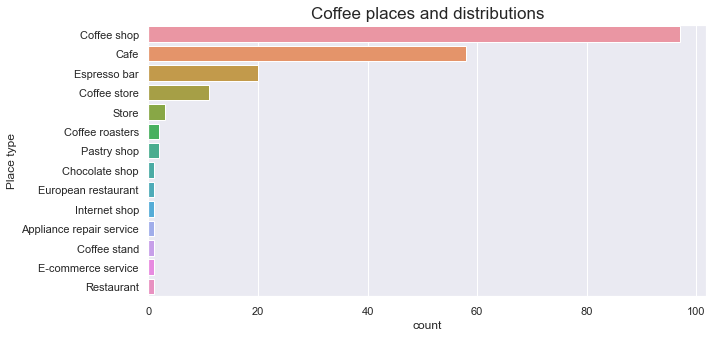

In [5]:
# show unique venues' distributions
sns.countplot(data=shops, y='Place type', 
              order=shops['Place type'].value_counts().index)

# set title and show
plt.title('Coffee places and distributions', fontsize=17)
plt.show()

#### 📝 Summary

From just a small number of code blocks we can see some important information:
- There are 10 regions each of which has 20 records. The dataset is evenly distributed. 
- 60% of the total data entries have at least one missing value. The majority of them fall into the last four columns: price, delivery, dine-in, and takeout options. Do they have a common pattern? Do reviews, ratings, and prices differ for the services? That's what we will investigate next. 
- Almost 50% of the dataset is comprised of coffee shops. The second plot reveals that 8 out of 10 regions have more coffee shops than any other venue. The two regions, Khrivoy Rog and Dnipro seem to have a bigger number of cafes. 

Since the missing value situation is pretty serious, we need to carefully investigate each column and choose an appropriate imputation (filling in the missing values) tool. However, before we start doing so, it's quite important to see the outlier situation because it can introduce errors into the dataset. Therefore, the next step is going to target the outlier situation. 

### Data Cleaning  <a class="anchor" id="clean"/>

This part consists of a series of steps that involve looking into the missing value condition, finding patterns, imputing and putting the entries into the same format. The process will follow the following format:

- Understand the nature of missing values
- Deal with missing values
- Deal with outliers
- Deal with duplicates

#### Understand the nature of missing values

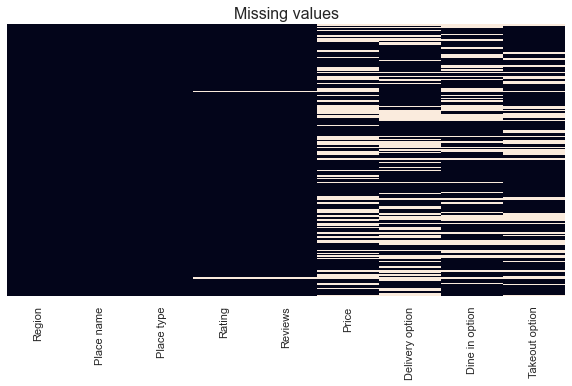

In [6]:
# look into the distribution of missing values
viz.missing_vals(shops)

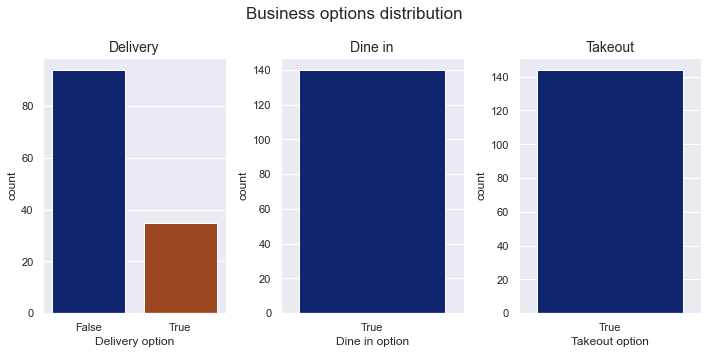

In [7]:
# look into the last three columns and
# see if there is a pattern in missing values
fig, ax = plt.subplots(1, 3)
fig.suptitle('Business options distribution', fontsize=17)
sns.countplot(shops['Delivery option'], ax=ax[0])
sns.countplot(shops['Dine in option'], ax=ax[1])
sns.countplot(shops['Takeout option'], ax=ax[2])

# set titles
ax[0].set_title('Delivery', fontsize=14)
ax[1].set_title('Dine in', fontsize=14)
ax[2].set_title('Takeout', fontsize=14)

# fix formatting and show the plot
plt.tight_layout()
plt.show()

#### 💡 Insight 

The side-by-side barplots show that the last two columns have only one recurring value. This raises a question, "Can we simply impute the rest of the data entries with False?". The answer is no. There are two main reasons for that:
- It can introduce the venues that don't provide any services: no delivery, no dine-in or takeout options. This would be a pretty useless business, wouldn't it? 
- There is a pattern for the missing values! 

A closer look into the place types showed that there was a mixture of cafes, stores, e-shops, and coffe-places. This means that such places as e-shops and repair shops introduced the necessity to include "takeout" column (other places are required to have such an option). After careful consideration, I have narrowed down the imputation process into the following steps:
 
- Cafes and restaurants **must** have both dine-in and takeout options
- E-shops and appliance/convenience/service stores **cannot** have any of the options because they can sell a lot of other things at the same time. Here we have two options: drop the values or put them onto the same category "Other". 
- All places **except** for e-shops and service shops should have a takeout option 



#### Deal with missing values

##### Fix delivery column

In [8]:
# get columns that need to have delivery option
places = ['Store', 'Appliance repair service', 'E-commerce service']
cols = shops.columns[-3:]

# get indices of entries with no delivery 
idx = shops[(shops[cols[0]] == False) & 
            (shops[cols[1]] == False) & 
            (shops[cols[2]] == False) &
            (~shops['Place type'].isin(places))].index

# enable delivery
shops.loc[idx, 'Delivery option'] = True

##### Cafes & Restaurants

In [9]:
# select place types 
dinein_venues = ['Cafe', 'Restaurant', 'European restaurant']

# get indices of venues with missing or disabled dine-in options
dinein = shops[(shops['Place type'].isin(dinein_venues)) & 
               ((shops['Dine in option'] == False) | 
                (shops['Dine in option'].isna()) | 
                (shops['Takeout option'] == False) |
                (shops['Takeout option'].isna()))]

print(f'Number of data entries: {len(dinein)}')
dinein.head(3)

Number of data entries: 20


,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
23,Poltava,Coffee House,Cafe,4.7,329.0,$$,False,NaN,True
25,Poltava,Your Coffee,Cafe,4.7,569.0,$$,False,True,NaN


In [10]:
# set last two columns to true 
shops.loc[dinein.index, ['Dine in option', 'Takeout option']] = True

# verify the changes
assert len(shops[(shops['Place type'].isin(dinein_venues)) & 
                 ((shops['Dine in option'] == False) | 
                  (shops['Dine in option'].isna()))]) == 0

##### E-commerce services and Internet shops

In [11]:
# select the columns to disable
cols = ['Delivery option', 'Dine in option', 'Takeout option']

# select place types that should have options disabled
other = ['Internet shop', 'Appliance repair service', 'Store', 'E-commerce service']

# define a function to change the option types
change_type = lambda x: 'Other' if x in other else x 

# fill in the values
eshops = shops[shops['Place type'].isin(other)].index 
shops.loc[eshops, cols] = False 
shops['Place type'] = shops['Place type'].apply(lambda x: change_type(x))

# verify the changes
shops.loc[eshops]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
61,Zaporozhye,Art Coffee - Інтернет Магазин Кави та Чаю,Other,5.0,12.0,NaN,False,False,False
63,Zaporozhye,"Мастерская ""Кофе на разлив""",Other,5.0,15.0,NaN,False,False,False
68,Zaporozhye,Coffee House,Other,4.7,132.0,NaN,False,False,False
82,Odessa,Кофе База Одесса | Coffee Baza,Other,5.0,10.0,NaN,False,False,False
141,Kiev,"""®КАВА БАЗА®""",Other,5.0,21.0,NaN,False,False,False
181,Dnipro,Dim Kavy,Other,4.9,39.0,NaN,False,False,False


##### Takeout option

In [12]:
# enable takeout option for everything except for "Other"
idx = shops[~shops['Place type'].isin(['Other'])].index
shops.loc[idx, 'Takeout option'] = True 

##### Dine in option

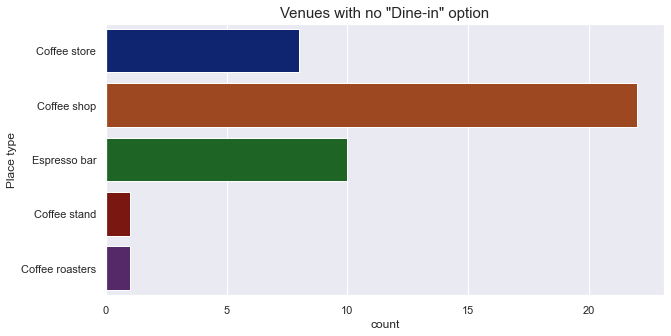

In [13]:
# select venues with missing Dine-in option
no_dinein = shops[shops['Dine in option'].isna()]

# visualize the distributions
plt.title('Venues with no "Dine-in" option', fontsize=15)
sns.countplot(data=no_dinein, y='Place type')
plt.show()

The venues and their distributions make sense to not have a "Dine-in" option, therefore it's safe to fill in the missing values with False. 


In [14]:
# fill in the missing values 
shops.loc[no_dinein.index, 'Dine in option'] = False

##### Delivery option

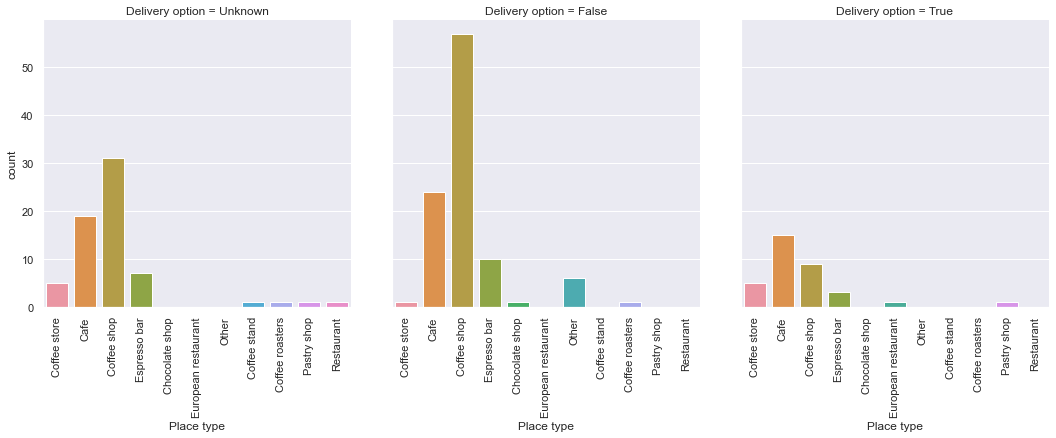

In [15]:
# fill in the delivery option with "Unknown"
no_delivery = shops[shops['Delivery option'].isna()].index
shops.loc[no_delivery, 'Delivery option'] = 'Unknown'

# display the distributions
g = sns.catplot(data=shops, x='Place type', col='Delivery option', kind='count')
g.set_xticklabels(rotation=90)
plt.show()

In [16]:
# verify there are no "all false" options except for "Other" place types
shops[(shops['Dine in option'] == False) & 
      (shops['Delivery option'] == False) & 
      (shops['Takeout option'] == False)]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
61,Zaporozhye,Art Coffee - Інтернет Магазин Кави та Чаю,Other,5.0,12.0,NaN,False,False,False
63,Zaporozhye,"Мастерская ""Кофе на разлив""",Other,5.0,15.0,NaN,False,False,False
68,Zaporozhye,Coffee House,Other,4.7,132.0,NaN,False,False,False
82,Odessa,Кофе База Одесса | Coffee Baza,Other,5.0,10.0,NaN,False,False,False
141,Kiev,"""®КАВА БАЗА®""",Other,5.0,21.0,NaN,False,False,False
181,Dnipro,Dim Kavy,Other,4.9,39.0,NaN,False,False,False


In [17]:
# verify there are no cafes and restaurants with disabled dine-in option
shops[(shops['Place type'].isin(['Cafe', 'Restaurant'])) & (shops['Dine in option'] == False)]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option


We see above that the "Reviews" column has a kurtosis score of almost 120 which is bad. Let's investigate the data points and decide what to do with them next. 

##### Price, Rating, and Reviews columns

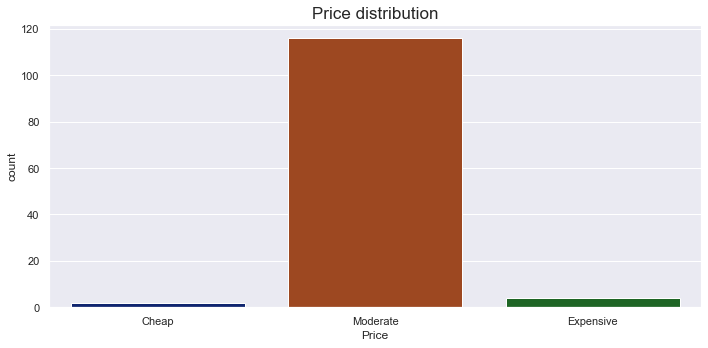

In [18]:
# create a map to have better visualization
mapping = {'$': 'Cheap', '$$': 'Moderate', '$$$': 'Expensive'}

# construct a countplot
sns.countplot(x=shops['Price'].replace(mapping).dropna(),
              order=['Cheap', 'Moderate', 'Expensive'])

# set title and show
plt.title('Price distribution', fontsize=17)
plt.tight_layout()
plt.show()

In [19]:
# fill in the missing values
shops['Price'].fillna('$$', inplace=True)

In [20]:
# get a dictionary for ratings and reviews columns
ratings_mean = shops.groupby('Place type')['Rating'].mean().to_dict()
reviews_median = shops.groupby('Place type')['Reviews'].median().to_dict()

In [21]:
# fix the missing values
shops.loc[49, 'Rating'] = round(ratings_mean['Cafe'], 2)
shops.loc[49, 'Reviews'] = reviews_median['Cafe']

shops.loc[186, 'Rating'] = round(ratings_mean['Coffee shop'], 2)
shops.loc[186, 'Reviews'] = reviews_median['Coffee shop']

In [22]:
# verify there are no missing values
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           200 non-null    float64
 4   Reviews          200 non-null    float64
 5   Price            200 non-null    object 
 6   Delivery option  200 non-null    object 
 7   Dine in option   200 non-null    object 
 8   Takeout option   200 non-null    object 
dtypes: float64(2), object(7)
memory usage: 14.2+ KB


#### Deal with outliers

One of the best tools to check the outlier condition is by checking the curtosis score. It's essentially a tool that lets you see how far the tails are using a normal distribution. It's acceptable to have curtosis score in the range of -3 and 3. 


Curtosis score
Rating              1.096487
Reviews           120.469577
Dine in option     -0.500109
Takeout option     29.116958
dtype: float64


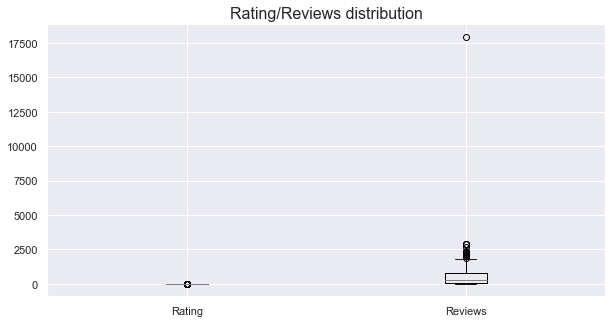

In [23]:
# calculate curtosis score
print('Curtosis score')
print(shops.kurtosis())

# show a boxplot representation of the numeric columns
shops.boxplot().set_title('Rating/Reviews distribution', fontsize=16)
plt.show()

In [24]:
# check the entries that are 3 standard deviations away from the mean
shops[shops['Reviews'] > shops['Reviews'].std() * 3]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
100,Lviv,Lviv Coffee Manufacture,Coffee shop,4.7,17937.0,$$,True,True,True


In [25]:
# drop the outlier
shops.drop(index=100, axis='rows', inplace=True)

# reset the indices such that there's no gap
shops.reset_index(drop=True)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,Unknown,False,True
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,True,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,Unknown,False,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,$$,Unknown,True,True
...,...,...,...,...,...,...,...,...,...
194,Dnipro,Artist,Restaurant,4.6,963.0,$$$,Unknown,True,True
195,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True
196,Dnipro,РУТА КАФЕ ПП КУЛІЧЕНКО К.І.,Cafe,4.6,16.0,$$,False,True,True
197,Dnipro,Ob'yektna Kava,Coffee shop,4.7,599.0,$$,Unknown,True,True


#### Potential duplicates

It's always a good practice to check the dataset for duplicates. We see that there are 187 unique place names. However, can there be duplicates just because the names are written in ALL CAPS or have everything in lower case? Let's look into that! 

In [26]:
# show the number of unique place names
print('Number of unique place names before cleaning', len(shops['Place name'].unique()))

# put every place name into the same format
shops['Place name'] = shops['Place name'].apply(lambda x: x.title())

# show the cleaned unique place names
print('Number of unique place names after cleaning', len(shops['Place name'].unique()))

Number of unique place names before cleaning 187
Number of unique place names after cleaning 183


##### Finishing touches

One last thing to do is to fix categories. Why is it important? Doing so saves a lot of space. It's always a good practice to do so. That's why let's keep the standards even with 200 entries!

In [27]:
# select categorical data
numeric = shops.select_dtypes([np.number]).columns.tolist()
columns = shops.columns.tolist()

# set the types accordingly
cat = list(set(columns).difference(set(numeric)))
shops[cat] = shops[cat].astype('category')

# verify changes
shops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Region           199 non-null    category
 1   Place name       199 non-null    category
 2   Place type       199 non-null    category
 3   Rating           199 non-null    float64 
 4   Reviews          199 non-null    float64 
 5   Price            199 non-null    category
 6   Delivery option  199 non-null    category
 7   Dine in option   199 non-null    category
 8   Takeout option   199 non-null    category
dtypes: category(7), float64(2)
memory usage: 13.0 KB


### Exploratory data analysis

To better understand the data at hand, I want to get answers for the following questions:

1. What's the most common place in each region?
2. What are the reviews for the most popular places?
3. What's the best rated place in each region?
4. Do big cities have different trends than the smaller ones?
5. Do prices/reviews/ratings differ if there's a delivery option?


To start answering the questions, let's first google some information about the Ukrainian cities and their populations.

| Region | Population | Most Common Place | Most Reviews | 
| --- | --- | --- | --- |
| Kyiv (Kiev) | 2,962,180 | NaN | NaN |
| Kharkiv | 1,433,886 | NaN | NaN |
| Odessa | 1,015,826 | NaN | NaN |
| Dnipro | 980,948 | NaN | NaN |
| Zaporozhye | 722,713 | NaN | NaN |
| Lviv | 721,510 | NaN | NaN |
| Khrivoy Rog | 612,750 | NaN | NaN |
| Mariupol | 431,859 | NaN | NaN |
| Kherson | 283,649 | NaN | NaN |
| Poltava | 283,402 | NaN | NaN |

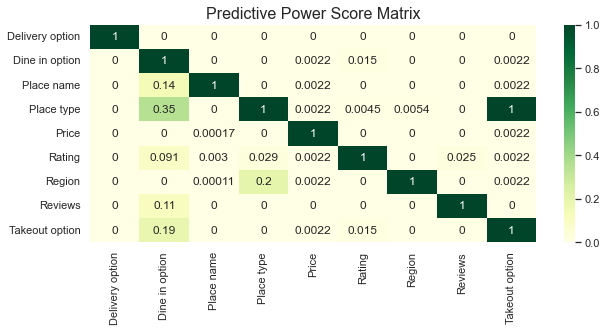

In [28]:
viz.pps_matrix(shops)

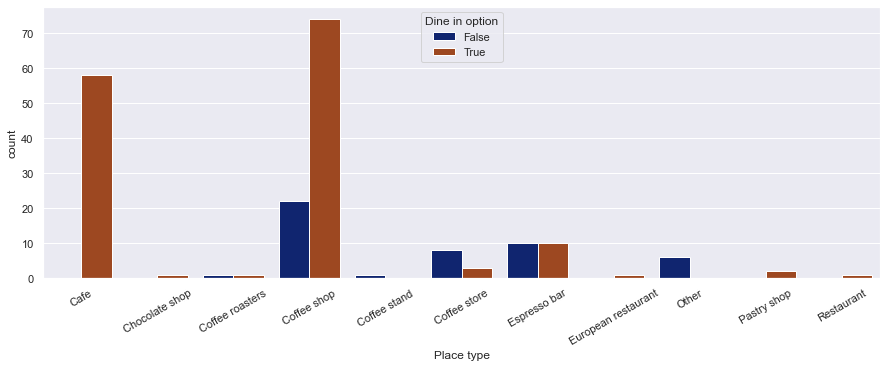

In [61]:
plt.figure(figsize=(15, 5))
sns.countplot(data=shops, x='Place type', hue='Dine in option')
plt.xticks(rotation=30)
plt.show()

## Question 1: What's the most common place in each region?

From what we see below, the most common places are coffee shops that account for 80% of the cities. The other two cities, Dnipro and Khrivoy Rog, have more cafes over others. From looking at the population, we see that both cities have less than 1,000,000 population and can be considered to be cities. 

This raises a series of questions:
- Do bigger cities have different trends? 
- What's more popular: takeaway, dine-in, or delivery option? 


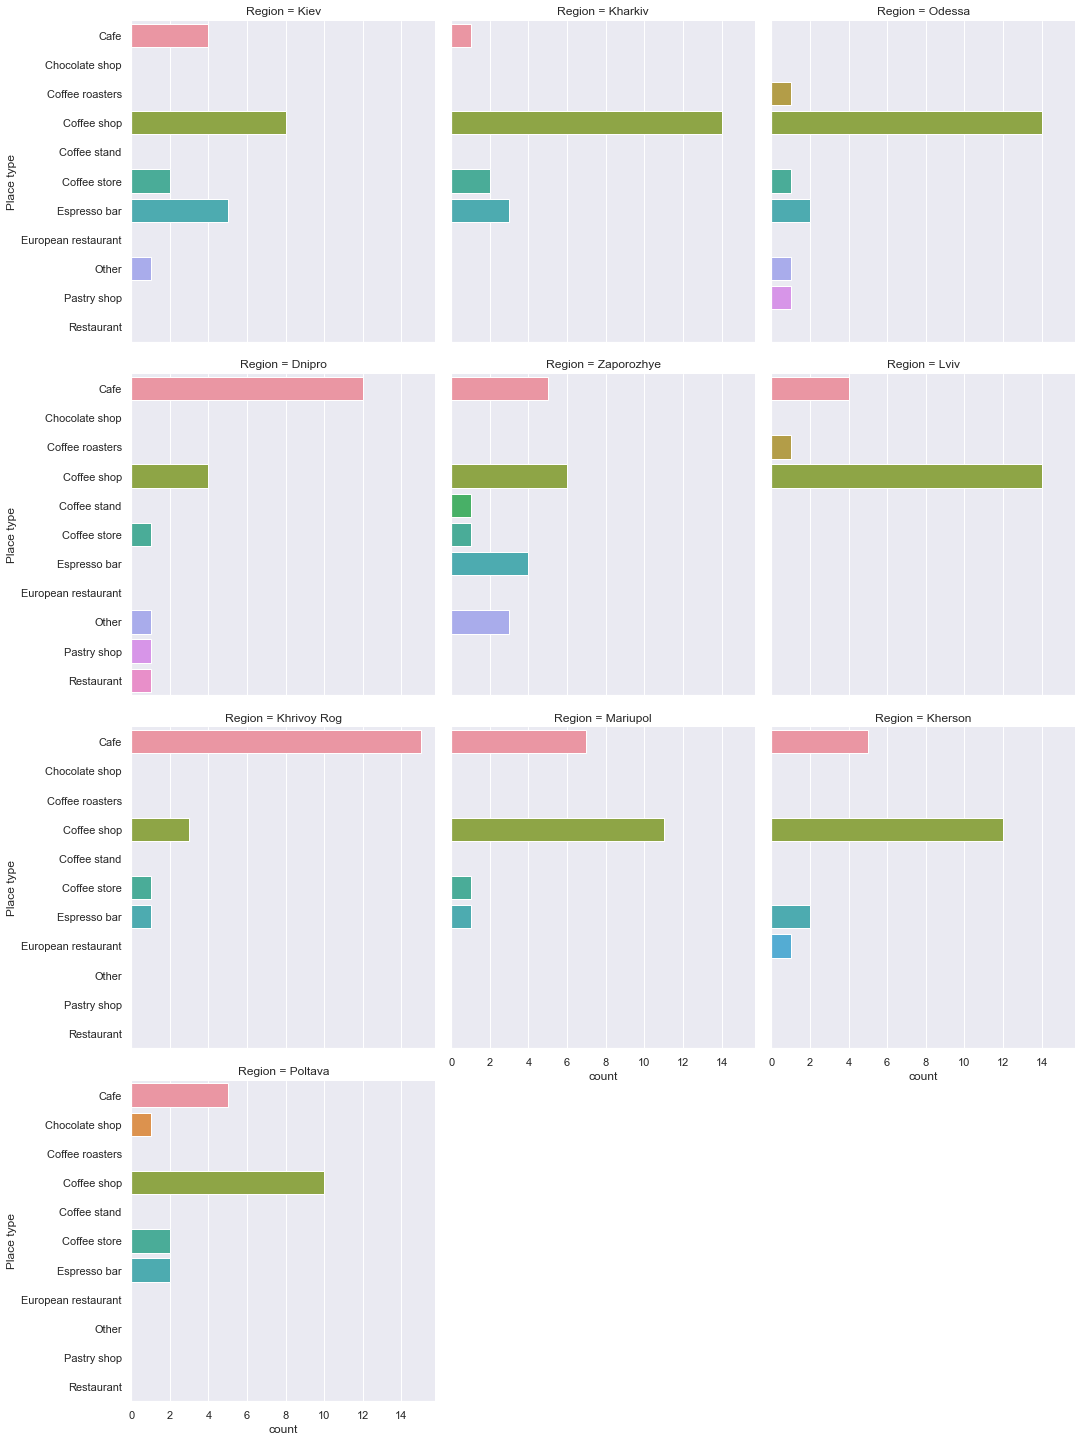

In [111]:
order = ['Kiev', 'Kharkiv', 'Odessa', 'Dnipro', 'Zaporozhye', 
         'Lviv', 'Khrivoy Rog', 'Mariupol', 'Kherson', 'Poltava']

sns.catplot(data=shops, y='Place type', kind='count', 
            col='Region', col_wrap=3, col_order=order)
plt.show()

In [112]:
places = shops.groupby('Region')['Place type'].value_counts().rename('count').\
               reset_index().groupby('Region').first()

places['ratio'] = round(places['count'] / 20, 2)
places

,level_1,count,ratio
Region,,,
Dnipro,Cafe,12,0.60
Kharkiv,Coffee shop,14,0.70
Kherson,Coffee shop,12,0.60
Khrivoy Rog,Cafe,15,0.75
Kiev,Coffee shop,8,0.40
Lviv,Coffee shop,14,0.70
Mariupol,Coffee shop,11,0.55
Odessa,Coffee shop,14,0.70
Poltava,Coffee shop,10,0.50


In [114]:
shops

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,Unknown,False,True
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,True,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,Unknown,False,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,$$,Unknown,True,True
...,...,...,...,...,...,...,...,...,...
195,Dnipro,Artist,Restaurant,4.6,963.0,$$$,Unknown,True,True
196,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True
197,Dnipro,Рута Кафе Пп Куліченко К.І.,Cafe,4.6,16.0,$$,False,True,True
198,Dnipro,Ob'Yektna Kava,Coffee shop,4.7,599.0,$$,Unknown,True,True


In [116]:
shops['Place type'].value_counts()

Coffee shop            96
Cafe                   58
Espresso bar           20
Coffee store           11
Other                   6
Coffee roasters         2
Pastry shop             2
Chocolate shop          1
Coffee stand            1
European restaurant     1
Restaurant              1
Name: Place type, dtype: int64

## Question 2: Do big cities have different trends than the smaller ones?

In order to answer the question, we will first define how big the "big" city is. After some googling, I found the following information:

| Term | Population | 
| --- | --- |
| Metropolis | 1,000,000 - 3,000,000 |
| City | 300,000 - 1,000,000 |
| County | 100,000 - 300,000 |

We see here that we can break the dataset into three categories: county, city, and metropolis. Let's compare the trends in each.

In [64]:
# create the mapping to separate megapolis, city, and counties
def mapping(x):
    if x in ['Kiev', 'Kharkiv', 'Odessa']:
        return 'Metropolis'
    if x in ['Kherson', 'Poltava']:
        return 'County'
    return 'City'


shops['Division'] = shops['Region'].apply(lambda x: mapping(x))
shops.head(3)

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Division
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,Unknown,False,True,City
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,True,True,City
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,Unknown,False,True,City


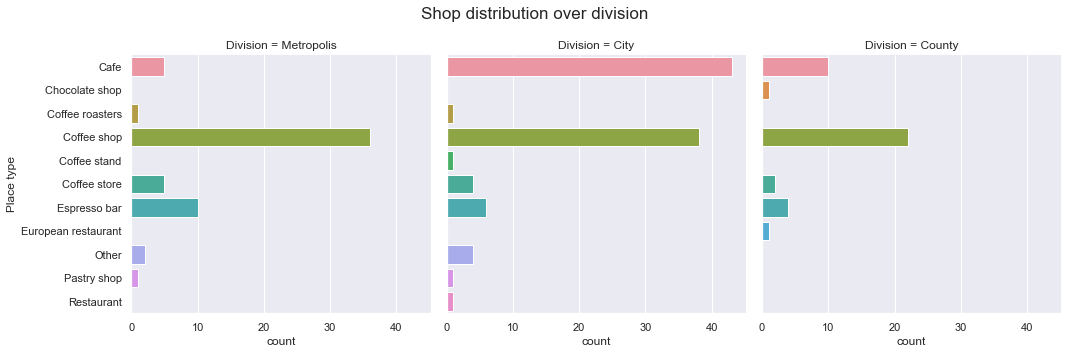

In [71]:
g = sns.catplot(data=shops, y='Place type', 
            kind='count', col='Division', 
            col_order=['Metropolis', 'City', 'County'])
g.fig.suptitle('Shop distribution over division', fontsize=17)
plt.tight_layout()
plt.savefig('divisions.png')
plt.show()

### Insights: Coffee shops vs Cafes

While coffee shops are popular in each of region, we see how much more cafes in cities than metropolis and counties taken together. We can also see one more trend - the bigger the city - the bigger the number of espresso bars. 

## Question 3: What are the reviews for the most popular places?

In [57]:
reviews = shops.groupby(['Region', 'Place type'])['Reviews'].sum().reset_index()

reviews.sort_values('Reviews', ascending=False).groupby('Region').first()

,Place type,Reviews
Region,,
Dnipro,Cafe,4199.0
Kharkiv,Coffee shop,8714.0
Kherson,Coffee shop,4173.0
Khrivoy Rog,Cafe,7478.0
Kiev,Espresso bar,4760.0
Lviv,Coffee shop,33601.0
Mariupol,Cafe,2029.0
Odessa,Coffee shop,6806.0
Poltava,Coffee shop,5628.0


In [58]:
shops[shops['Reviews'] > shops['Reviews'].std() * 3]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Division
100,Lviv,Lviv Coffee Manufacture,Coffee shop,4.7,17937.0,$$,True,True,True,City


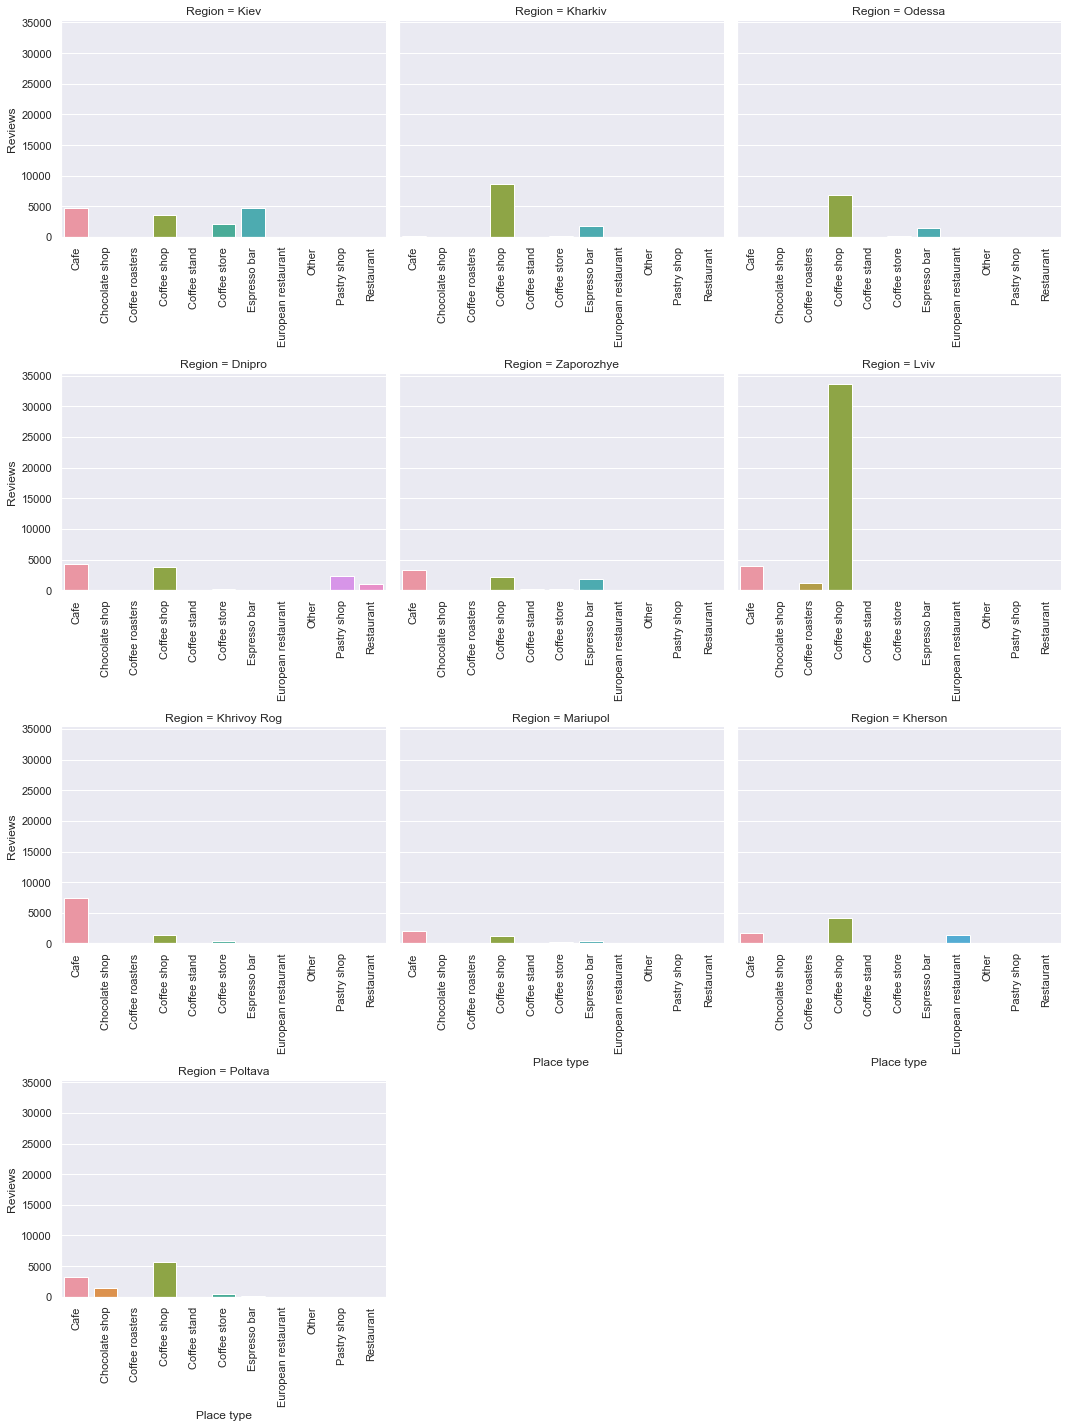

In [59]:
g = sns.catplot(data=reviews, x='Place type', y='Reviews', kind='bar', 
                col='Region', col_wrap=3, col_order=order)
for ax in g.axes:
    ax.set_xticklabels(reviews['Place type'].unique(), rotation=90)
    ax.tick_params(labelbottom=True)
    
plt.subplots_adjust(bottom=0.1, left=0.06, hspace=0.2)
plt.tight_layout()
plt.show()

## Question 4: What's the best rated place in each region?

In [60]:
rating = shops.groupby(['Region', 'Place type'])['Rating'].mean().reset_index()

rating.sort_values('Rating', ascending=False).groupby('Region').first()

,Place type,Rating
Region,,
Dnipro,Pastry shop,4.700000
Kharkiv,Coffee shop,4.607143
Kherson,Espresso bar,4.700000
Khrivoy Rog,Espresso bar,4.800000
Kiev,Coffee shop,4.850000
Lviv,Cafe,4.750000
Mariupol,Coffee shop,4.745455
Odessa,Coffee roasters,5.000000
Poltava,Espresso bar,4.850000


## Question 5: What's the most voted and reviewed places in each region?

In [61]:
shops.groupby(['Region', 'Place type'])[['Reviews', 'Rating']].mean().\
      reset_index().sort_values(['Region', 'Reviews', 'Rating'], ascending=False).\
      groupby('Region').first()

,Place type,Reviews,Rating
Region,,,
Dnipro,Pastry shop,2381.000000,4.700000
Kharkiv,Coffee shop,622.428571,4.607143
Kherson,European restaurant,1345.000000,4.500000
Khrivoy Rog,Cafe,498.533333,4.580000
Kiev,Cafe,1169.250000,4.725000
Lviv,Coffee shop,2240.066667,4.653333
Mariupol,Espresso bar,367.000000,4.600000
Odessa,Espresso bar,725.500000,4.800000
Poltava,Chocolate shop,1376.000000,4.600000


## Question 6: Do reviews/ratings change depending on delivery/dine-in options?

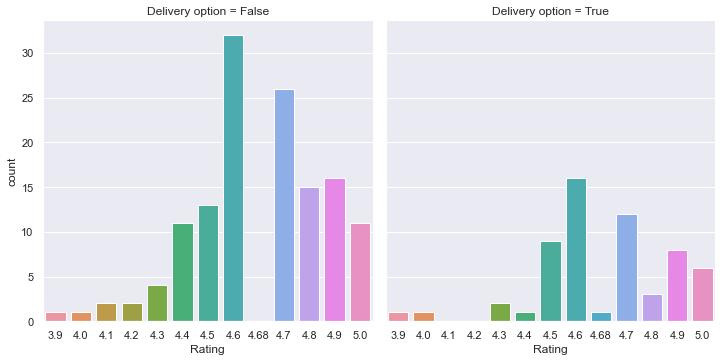

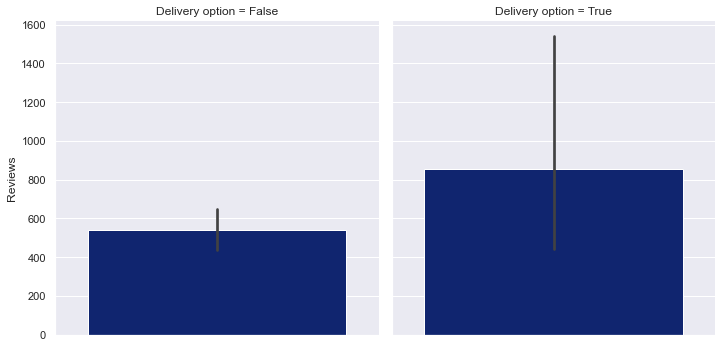

In [62]:
sns.catplot(data=shops, x='Rating', kind='count', col='Delivery option')
plt.show()

sns.catplot(data=shops, y='Reviews', kind='bar', col='Delivery option')
plt.show()

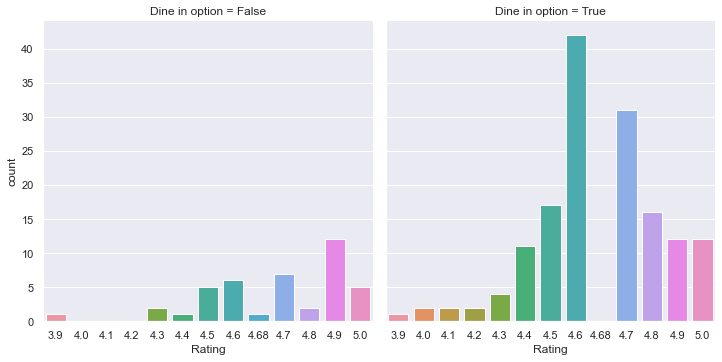

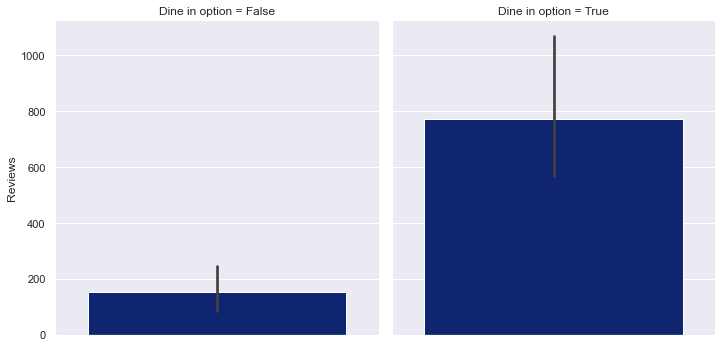

In [63]:
sns.catplot(data=shops, x='Rating', kind='count', col='Dine in option')
plt.show()

sns.catplot(data=shops, y='Reviews', kind='bar', col='Dine in option')
plt.show()

### Insights

Here we see the following picture 

| Region | Population | Division | Most Common Place | Most Average Reviews | Most Average Rating
| --- | --- | --- | --- | --- | --- |
| Kyiv (Kiev) | 2,962,180 | Metroplis | Coffee shop (40%) | Cafe (1169) | Other (e-shops & service shops) |
| Kharkiv | 1,433,886 | Metroplis |Coffee shop (70%) | Coffee shop (622) | Espresso bar |
| Odessa | 1,015,826 | Metroplis | Coffee shop (70%) | Espresso bar (726) | Coffee roasters |
| Dnipro | 980,948 | City | Cafe (60%) | Pastry shop (2381) | Store |
| Zaporozhye | 722,713 | City |Coffee shop (30%) | Cafe (661) | Other (e-shops & service shops) |
| Lviv | 721,510 | City | Coffee shop (70%) | Coffee roasters (1199) | Cafe |
| Khrivoy Rog | 612,750 | City | Cafe (75%) | Coffee shop (499) | Espresso bar |
| Mariupol | 431,859 | City | Coffee shop (55%) | Espresso bar (367) | Coffee shop |
| Kherson | 283,649 | Town | Coffee shop (60%) | European restaurant (1345) | Espresso bar |
| Poltava | 283,402 | Town | Coffee shop (50%) | Chocolate shop (1376) | Coffee store |

## Cluster Analysis

In [117]:
scaler = StandardScaler()

cleaned = shops.copy()
cleaned['scaled_rating'] = scaler.fit_transform(cleaned[['Rating']])
cleaned['scaled_reviews'] = scaler.fit_transform(cleaned[['Reviews']])

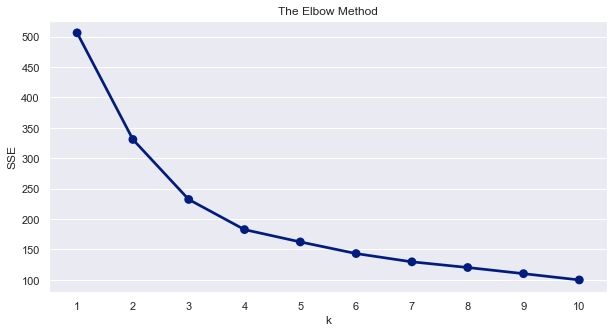

In [118]:
data = cleaned[['scaled_rating', 'scaled_reviews', 'Dine in option', 'Delivery option']]
data = pd.get_dummies(data, drop_first=True)

#find the elbow to determine the optimal number of clusters
sse={}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data)
    sse[k] = kmeans.inertia_

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

In [119]:
kmeans = KMeans(4, random_state=1).fit(data)
cleaned['cluster'] = kmeans.labels_

In [124]:
mode = lambda x: x.mode()

cleaned.groupby('cluster').agg({'Rating': [np.min, np.max, np.mean],
                              'Reviews': [np.min, np.max, np.mean], 
                              'Delivery option': mode,
                              'Dine in option': mode,
                              'Place type': 'count'})

Rating                Reviews                      Delivery option  \
          amin amax      mean    amin    amax         mean        <lambda>   
cluster                                                                      
0         3.90  4.7  4.533684     3.0  1009.0   372.905263           False   
1         4.68  5.0  4.886471    10.0   858.0   116.691176         Unknown   
2         4.00  4.9  4.583333   998.0  2931.0  1738.194444            True   

        Dine in option Place type  
              <lambda>      count  
cluster                            
0                 True         95  
1                 True         68  
2                 True         36

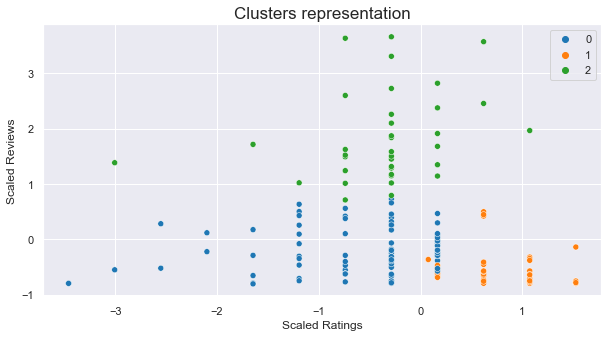

In [121]:
# Plot clusters
sns.scatterplot(x='scaled_rating', y='scaled_reviews', 
                hue='cluster', data=cleaned, palette='tab10')

# Put the legend out of the figure
plt.title('Clusters representation', fontsize=17)
plt.legend(loc='best')
plt.xlabel('Scaled Ratings')
plt.ylabel('Scaled Reviews')
plt.show()


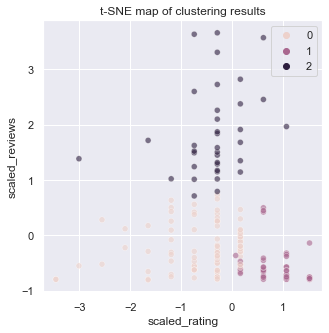

In [122]:
def tsne_map(features, l_rate=100):
    """Create and plot tsne map based on the created matrix"""
    tsne_output = TSNE(learning_rate=l_rate).fit_transform(features.drop('cluster', axis=1))
    tsne_df = pd.DataFrame(index=features.index)
    tsne_df['x'] = tsne_output[:, 0]
    tsne_df['y'] = tsne_output[:, 1]
    
    # Separate SPb cluster from others
    # tsne_df['cluster'] = 0
    # spb_cluster = features.loc['Saint Petersburg', 'cluster']
    # tsne_df.loc[features.cluster == spb_cluster, 'cluster'] = 1


    fig, ax = plt.subplots(figsize=(5, 5))
    sns.scatterplot(data=features, x='scaled_rating', y='scaled_reviews', 
                    hue='cluster',
                    alpha=0.6,
                    ax=ax)
    ax.set_title('t-SNE map of clustering results')
    ax.legend()
    plt.show()
    
    
tsne_map(cleaned[['scaled_rating', 'scaled_reviews', 'cluster']])

In [123]:
cleaned[cleaned['cluster'] == 0]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,scaled_rating,scaled_reviews,cluster
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,Unknown,False,True,-0.286610,-0.498153,0
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True,-1.193372,-0.307343,0
5,Mariupol,Racers Coffee Shop,Espresso bar,4.6,367.0,$$,False,True,True,-0.286610,-0.252390,0
6,Mariupol,Займемся Кофе,Coffee shop,4.6,200.0,$$,False,True,True,-0.286610,-0.507312,0
7,Mariupol,Кофейня Rit Rit,Coffee shop,4.6,292.0,$$,False,False,True,-0.286610,-0.366876,0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,Dnipro,Artist,Restaurant,4.6,963.0,$$$,Unknown,True,True,-0.286610,0.657390,0
196,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True,-1.646752,0.173497,0
197,Dnipro,Рута Кафе Пп Куліченко К.І.,Cafe,4.6,16.0,$$,False,True,True,-0.286610,-0.788184,0
198,Dnipro,Ob'Yektna Kava,Coffee shop,4.7,599.0,$$,Unknown,True,True,0.166771,0.101752,0


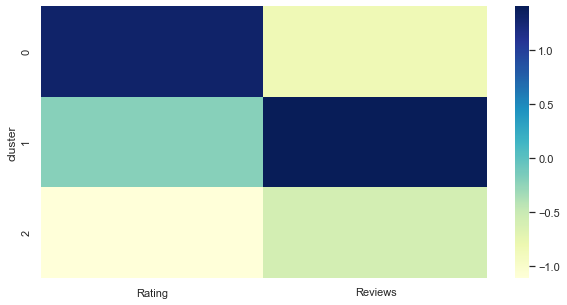

In [240]:
data_comparison = cleaned[['Rating', 'Reviews', 'cluster']].groupby('cluster').mean()
data_comparison[['Rating', 'Reviews']] = scaler.fit_transform(data_comparison[['Rating', 'Reviews']])

 
sns.heatmap(data_comparison[['Rating', 'Reviews']], cmap = 'YlGnBu')
plt.show()

In [241]:
shops

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,Division
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,True,False,False,City
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,False,True,City
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,False,False,True,City
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True,City
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,$$,False,True,True,City
...,...,...,...,...,...,...,...,...,...,...
195,Dnipro,Artist,Restaurant,4.6,963.0,$$$,False,True,True,City
196,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True,City
197,Dnipro,Рута Кафе Пп Куліченко К.І.,Cafe,4.6,16.0,$$,False,True,True,City
198,Dnipro,Ob'Yektna Kava,Coffee shop,4.7,599.0,$$,False,True,True,City


### K-Prototype


In [242]:
# Get the position of categorical columns
catColumnsPos = [cleaned.columns.get_loc(col) for col in list(cleaned.select_dtypes('category').columns)]
print('Categorical columns           : {}'.format(list(cleaned.select_dtypes('category').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Region', 'Place name', 'Place type', 'Price', 'Delivery option', 'Dine in option', 'Takeout option']
Categorical columns position  : [0, 1, 2, 5, 6, 7, 8]


In [243]:
cleaned.head(3)

cleaned.drop(['Division', 'scaled_rating', 'scaled_reviews', 'cluster'], axis='columns', inplace=True)

In [244]:
cleaned[['Delivery option', 'Dine in option', 'Takeout option']] = shops[['Delivery option', 'Dine in option', 'Takeout option']].astype('bool')

In [245]:
cleaned

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,True,False,False
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,False,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,$$,False,False,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,$$,False,True,True
...,...,...,...,...,...,...,...,...,...
195,Dnipro,Artist,Restaurant,4.6,963.0,$$$,False,True,True
196,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True
197,Dnipro,Рута Кафе Пп Куліченко К.І.,Cafe,4.6,16.0,$$,False,True,True
198,Dnipro,Ob'Yektna Kava,Coffee shop,4.7,599.0,$$,False,True,True


In [246]:
df = cleaned.copy()
rating_scaler = StandardScaler().fit(df[['Rating']])
reviews_scaler = StandardScaler().fit(df[['Reviews']])


df['Rating'] = rating_scaler.fit_transform(df[['Rating']])
df['Reviews'] = reviews_scaler.fit_transform(df[['Reviews']])

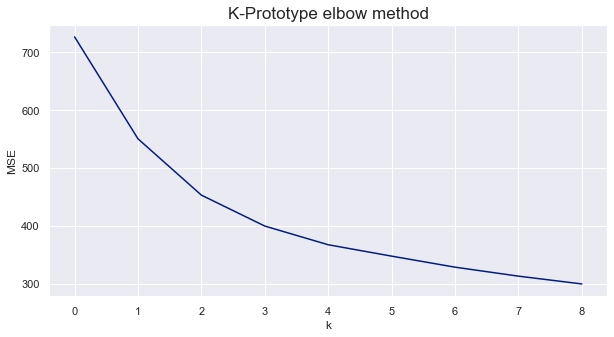

In [247]:
cost = []
dfMatrix = df.to_numpy()


for cluster in range(1, 10):
    kprototype = KPrototypes(n_jobs=-1, n_clusters=cluster, init='Huang', random_state=42)
    kprototype.fit_predict(dfMatrix, categorical=catColumnsPos)
    cost.append(kprototype.cost_)

        
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(len(cost)), 'Cost':cost})
plt.plot(range(len(cost)), cost)
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('K-Prototype elbow method', fontsize=17)
plt.show()

In [248]:
k_ptype = KPrototypes(n_jobs=-1, n_clusters=3, init='Huang', random_state=42)

df['clusters'] = k_ptype.fit_predict(dfMatrix, categorical=catColumnsPos)

In [249]:
df['clusters'].value_counts()

1    94
0    71
2    34
Name: clusters, dtype: int64

In [250]:
df['Reviews'] = reviews_scaler.inverse_transform(df['Reviews'])
df['Rating'] = rating_scaler.inverse_transform(df['Rating'])

df[df['clusters'] == 0]

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option,clusters
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,$$,True,False,False,0
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True,0
5,Mariupol,Racers Coffee Shop,Espresso bar,4.6,367.0,$$,False,True,True,0
6,Mariupol,Займемся Кофе,Coffee shop,4.6,200.0,$$,False,True,True,0
7,Mariupol,Кофейня Rit Rit,Coffee shop,4.6,292.0,$$,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...
190,Dnipro,"""Франс.Уа"" Кофейня-Пекарня",Cafe,3.9,9.0,$$,False,False,True,0
195,Dnipro,Artist,Restaurant,4.6,963.0,$$$,False,True,True,0
196,Dnipro,Dream Cafe,Cafe,4.3,646.0,$$,False,True,True,0
197,Dnipro,Рута Кафе Пп Куліченко К.І.,Cafe,4.6,16.0,$$,False,True,True,0


In [251]:
mode = lambda x: x.mode()

df.groupby('clusters').agg({'Place type': [mode, 'count'], 'Rating': np.mean, 'Reviews': np.mean,
                            'Delivery option': mode, 'Dine in option': mode})

Place type          Rating      Reviews Delivery option  \
           <lambda_0> count      mean         mean        <lambda>   
clusters                                                             
0         Coffee shop    71  4.461972   388.366197           False   
1         Coffee shop    94  4.834894   195.914894           False   
2         Coffee shop    34  4.608824  1763.117647           False   

         Dine in option  
               <lambda>  
clusters                 
0                  True  
1                  True  
2                  True

In [6]:
import pandas as pd

pd.read_csv('data/kmeans_3.csv')


,Cluster,Place type,Count,Rating,Reviews,Delivery option,Dine in option
0,0,Coffee shop,71,4.46,388,False,True
1,1,Coffee shop,94,4.83,196,False,True
2,2,Coffee shop,34,4.60,1763,False,True


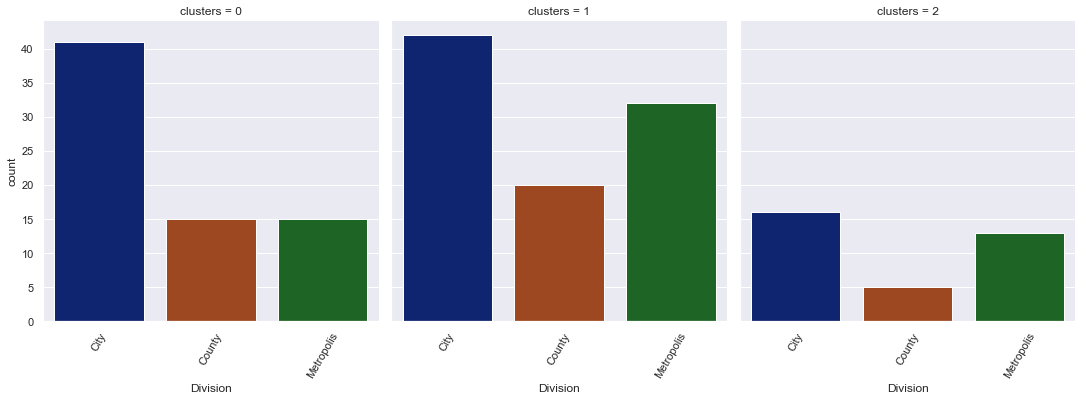

In [253]:
df['Division'] = shops['Division']
g = sns.catplot(data=df, x='Division', kind='count', col='clusters')
g.set_xticklabels(rotation=60)

In [7]:
# # sns.color_palette('dark', as_cmap=True)
# sns.catplot(data=df, y='Place type', col='clusters', kind='count')
# plt.show()

fig, ax = plt.subplots(1, 2)
sns.kdeplot(data=df, x='Rating', hue='clusters', ax=ax[0], palette='dark')
sns.kdeplot(data=df, x='Reviews', hue='clusters', ax=ax[1], palette='dark')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

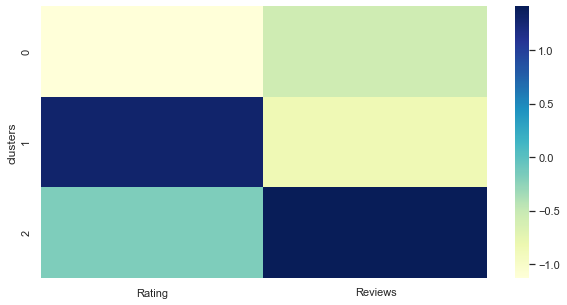

In [255]:
data_comparison = df[['Rating', 'Reviews', 'clusters']].groupby('clusters').mean()
data_comparison[['Rating', 'Reviews']] = scaler.fit_transform(data_comparison[['Rating', 'Reviews']])

sns.heatmap(data_comparison[['Rating', 'Reviews']], cmap = 'YlGnBu')
plt.show()

1. https://dash.plotly.com/interactive-graphing

### Key insights
- There are four main segments: 
- Coffee shops are the most common places (8/10 regions)
- 



## Final recommendation

From what we see above, the data can be clustered in either 3 or 4 segments. Either way, the predictions have somewhat similar outcomes. They can be divided in the following segments:

| Group | Rating | Review | Delivery | Dine-in & Takeout |
| --- | --- | --- | --- | --- |
| 0 | Low-Medium (3.9-4.4) | Average (avg=336) | No | Yes |
| 1 | High (4.7-5) | Low (avg=33) | Uknown | Yes |
| 2 | Medium-High (4.5-4.8) | Average (avg=292) | No | Yes |
| 3 | Medium-High (4.3-4.9) | High (avg=1596) | Yes/No | Yes |




